<a href="https://colab.research.google.com/github/bakshiaritracrow/pymc_gw_inference/blob/main/notebooks/pymc_gw_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pymc as pm
import numpy as np

def load_data(path):
    d = np.load(path)
    return {k: d[k] for k in d.files}

def build_model(data):
    N = len(data['m1'])
    with pm.Model() as model:
        # Hyperpriors for population means
        mu_m1 = pm.Uniform('mu_m1', 5, 50)
        mu_m2 = pm.Uniform('mu_m2', 5, 50)
        mu_chi_eff = pm.Uniform('mu_chi_eff', -1, 1)

        # Population spreads
        sigma_m1 = pm.HalfNormal('sigma_m1', 10)
        sigma_m2 = pm.HalfNormal('sigma_m2', 10)
        sigma_chi_eff = pm.HalfNormal('sigma_chi_eff', 0.3)

        # Individual binary parameters (hierarchical model)
        m1 = pm.Normal('m1', mu=mu_m1, sigma=sigma_m1, shape=N)
        m2 = pm.Normal('m2', mu=mu_m2, sigma=sigma_m2, shape=N)

        # Spins
        s1x = pm.Uniform('s1x', -0.99, 0.99, shape=N)
        s1y = pm.Uniform('s1y', -0.99, 0.99, shape=N)
        s1z = pm.Uniform('s1z', -0.99, 0.99, shape=N)
        s2x = pm.Uniform('s2x', -0.99, 0.99, shape=N)
        s2y = pm.Uniform('s2y', -0.99, 0.99, shape=N)
        s2z = pm.Uniform('s2z', -0.99, 0.99, shape=N)

        # Chirp mass (deterministic)
        chirp_mass = pm.Deterministic('chirp_mass', ((m1*m2)**(3/5))/((m1+m2)**(1/5)))

        # Chi effective (deterministic)
        chi_eff = pm.Deterministic('chi_eff', (s1z*m1 + s2z*m2)/(m1 + m2))

        # Likelihoods
        obs_m1 = pm.Normal('obs_m1', mu=m1, sigma=0.5, observed=data['m1'])
        obs_m2 = pm.Normal('obs_m2', mu=m2, sigma=0.5, observed=data['m2'])
        obs_s1x = pm.Normal('obs_s1x', mu=s1x, sigma=0.2, observed=data['s1x'])
        obs_s1y = pm.Normal('obs_s1y', mu=s1y, sigma=0.2, observed=data['s1y'])
        obs_s1z = pm.Normal('obs_s1z', mu=s1z, sigma=0.2, observed=data['s1z'])
        obs_s2x = pm.Normal('obs_s2x', mu=s2x, sigma=0.2, observed=data['s2x'])
        obs_s2y = pm.Normal('obs_s2y', mu=s2y, sigma=0.2, observed=data['s2y'])
        obs_s2z = pm.Normal('obs_s2z', mu=s2z, sigma=0.2, observed=data['s2z'])
        obs_chirp_mass = pm.Normal('obs_chirp_mass', mu=chirp_mass, sigma=1.0, observed=data['chirp_mass'])
        obs_chi_eff = pm.Normal('obs_chi_eff', mu=chi_eff, sigma=sigma_chi_eff, observed=data['chi_eff'])

    return model

In [ ]:
import numpy as np
import os

N = 1000  # Number of binaries
np.random.seed(42)

# Masses
m1 = np.random.uniform(5, 50, N)
m2 = np.random.uniform(5, m1)  # ensure m2 <= m1

# Spins: s1x, s1y, s1z, s2x, s2y, s2z
s1x = np.random.uniform(-0.99, 0.99, N)
s1y = np.random.uniform(-0.99, 0.99, N)
s1z = np.random.uniform(-0.99, 0.99, N)
s2x = np.random.uniform(-0.99, 0.99, N)
s2y = np.random.uniform(-0.99, 0.99, N)
s2z = np.random.uniform(-0.99, 0.99, N)

# Chirp mass
chirp_mass = ((m1 * m2)**(3/5)) / ((m1 + m2)**(1/5))

# Chi effective
chi_eff = (s1z * m1 + s2z * m2) / (m1 + m2)

os.makedirs("data", exist_ok=True)
np.savez('data/mock_binary_data.npz', m1=m1, m2=m2, s1x=s1x, s1y=s1y, s1z=s1z,
         s2x=s2x, s2y=s2y, s2z=s2z, chirp_mass=chirp_mass, chi_eff=chi_eff)
print("Mock binary data saved to data/mock_binary_data.npz")

Mock binary data saved to data/mock_binary_data.npz


In [ ]:
import pymc as pm
# from models.binary_system_model import load_data, build_model # Removed this line
import arviz as az
import os

data = load_data('data/mock_binary_data.npz')
model = build_model(data)

os.makedirs("results", exist_ok=True)
with model:
    trace = pm.sample(1000, tune=1000, target_accept=0.95)
    az.to_netcdf(trace, 'results/binary_system_trace.nc')
    print("Inference complete. Results saved to results/binary_system_trace.nc")

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Inference complete. Results saved to results/binary_system_trace.nc


In [ ]:
# Analyze Convergence Diagnostics
import arviz as az

# Display summary statistics and convergence diagnostics
summary = az.summary(trace, var_names=['mu_m1', 'mu_m2', 'mu_chi_eff', 'sigma_m1', 'sigma_m2', 'sigma_chi_eff'])
print("Convergence Diagnostics and Summary Statistics for Population Parameters:")
display(summary)

# You can also look at diagnostics for individual parameters if needed, but this will be very large.
# For example, for the first few individual m1 values:
# summary_m1_individual = az.summary(trace, var_names=['m1'], filter_vars="like", include_dims=["m1_dim_0"], index=[0, 1, 2, 3, 4])
# print("\nConvergence Diagnostics and Summary Statistics for first 5 individual m1 parameters:")
# display(summary_m1_individual)

Convergence Diagnostics and Summary Statistics for Population Parameters:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_m1,27.054,0.413,26.238,27.816,0.006,0.011,5157.0,1411.0,1.00
mu_m2,16.298,0.314,15.675,16.851,0.005,0.009,3712.0,1236.0,1.00
mu_chi_eff,-0.013,0.559,-0.955,0.904,0.009,0.010,4111.0,1287.0,1.00
sigma_m1,13.142,0.289,12.586,13.677,0.004,0.007,4908.0,1479.0,1.00
sigma_m2,10.108,0.218,9.697,10.508,0.003,0.006,4691.0,1371.0,1.00
sigma_chi_eff,0.006,0.003,0.002,0.011,0.001,0.000,3.0,11.0,1.55


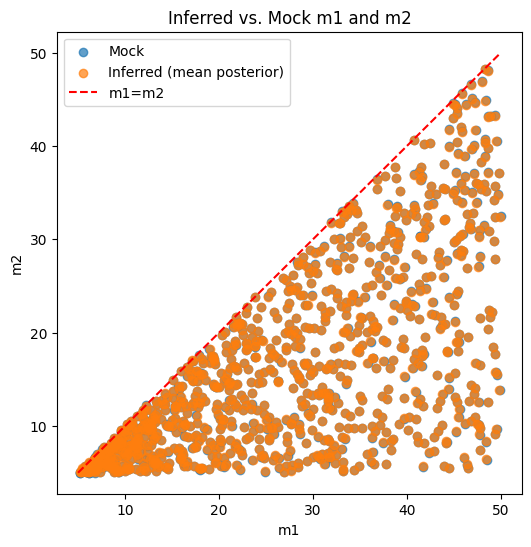

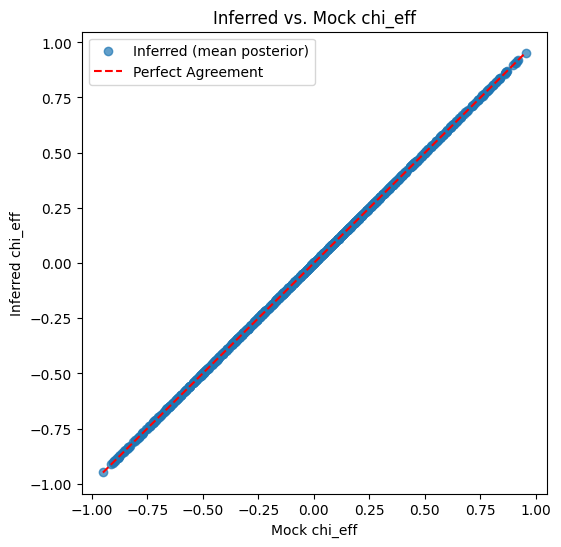

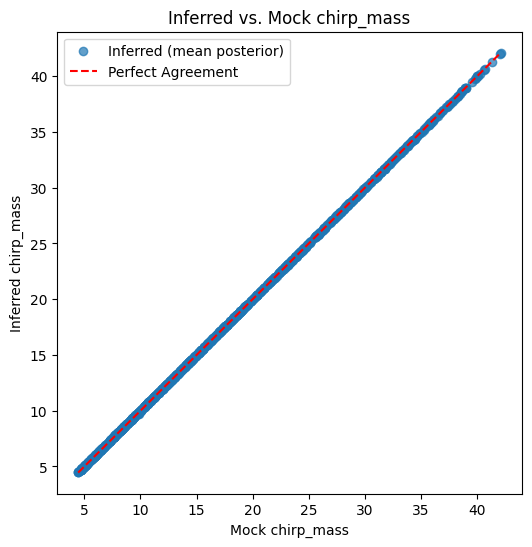

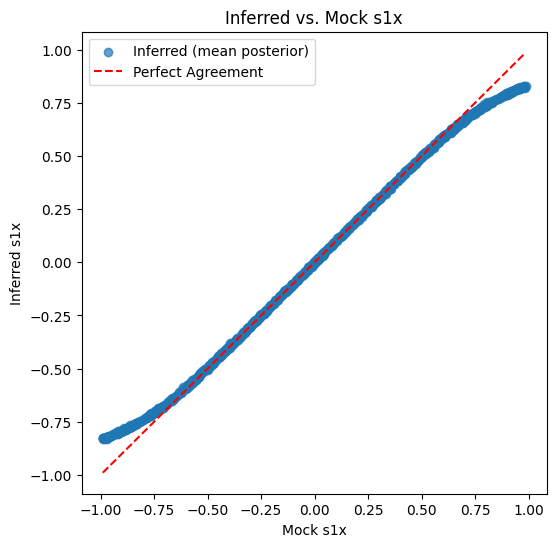

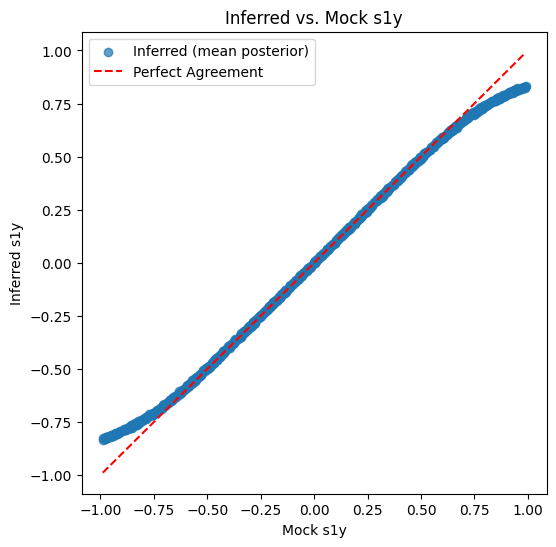

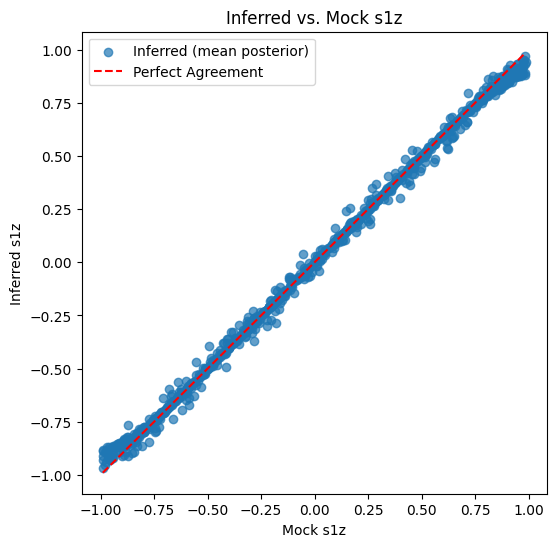

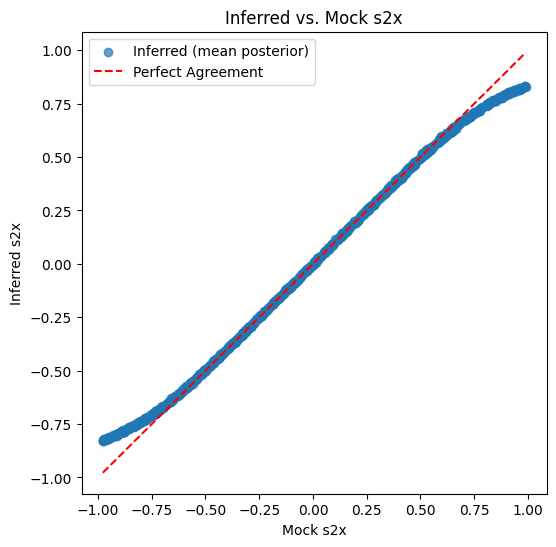

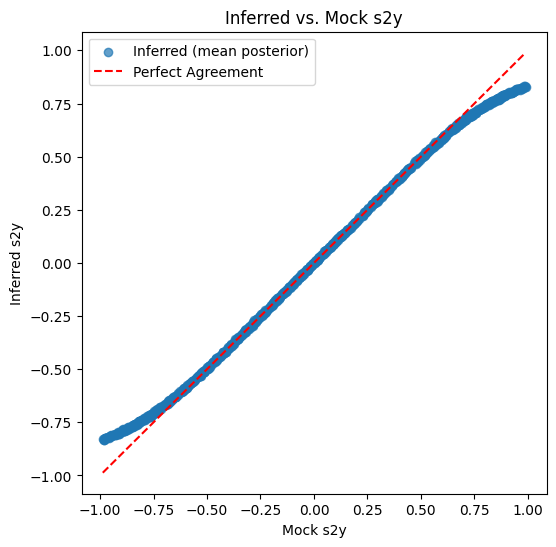

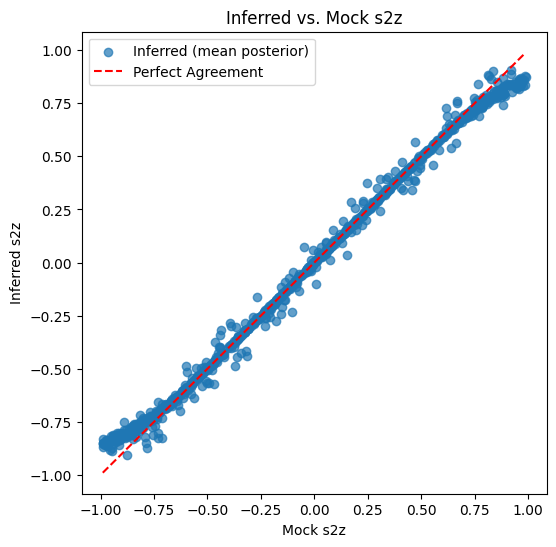

In [ ]:
# Cell 1: Imports and loading results
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

trace = az.from_netcdf('results/binary_system_trace.nc')


# Cell 4: Plotting inferred vs. mock values for all binaries (up to N)
m1_obs = trace.posterior['m1'].mean(dim=['chain', 'draw']).values[:N]
m2_obs = trace.posterior['m2'].mean(dim=['chain', 'draw']).values[:N]
chi_eff_obs = trace.posterior['chi_eff'].mean(dim=['chain', 'draw']).values[:N]
chirp_mass_obs = trace.posterior['chirp_mass'].mean(dim=['chain', 'draw']).values[:N]
s1x_obs = trace.posterior['s1x'].mean(dim=['chain', 'draw']).values[:N]
s1y_obs = trace.posterior['s1y'].mean(dim=['chain', 'draw']).values[:N]
s1z_obs = trace.posterior['s1z'].mean(dim=['chain', 'draw']).values[:N]
s2x_obs = trace.posterior['s2x'].mean(dim=['chain', 'draw']).values[:N]
s2y_obs = trace.posterior['s2y'].mean(dim=['chain', 'draw']).values[:N]
s2z_obs = trace.posterior['s2z'].mean(dim=['chain', 'draw']).values[:N]


# Assuming 'data' is available from a previous cell execution
# If 'data' is not available, you would need to reload it.
# For now, assuming 'data' is a global variable or reloaded here for clarity.
# data = load_data('data/mock_binary_data.npz') # Uncomment if data is not available

# m1 vs m2
plt.figure(figsize=(6, 6)) # Create a new figure for each plot
plt.scatter(data['m1'][:N], data['m2'][:N], label='Mock', alpha=0.7)
plt.scatter(m1_obs, m2_obs, label='Inferred (mean posterior)', alpha=0.7)
plt.xlabel('m1')
plt.ylabel('m2')
plt.title('Inferred vs. Mock m1 and m2')
plt.legend()

# Add the m1=m2 line
min_mass = min(np.min(data['m1'][:N]), np.min(data['m2'][:N]), np.min(m1_obs), np.min(m2_obs))
max_mass = max(np.max(data['m1'][:N]), np.max(data['m2'][:N]), np.max(m1_obs), np.max(m2_obs))
plt.plot([min_mass, max_mass], [min_mass, max_mass], color='red', linestyle='--', label='m1=m2')
plt.legend() # Update legend to include the new line

plt.show()

# List of variables to plot
vars_to_plot = {
    'chi_eff': chi_eff_obs,
    'chirp_mass': chirp_mass_obs,
    's1x': s1x_obs,
    's1y': s1y_obs,
    's1z': s1z_obs,
    's2x': s2x_obs,
    's2y': s2y_obs,
    's2z': s2z_obs
}

for var_name, obs_values in vars_to_plot.items():
    plt.figure(figsize=(6, 6)) # Create a new figure for each plot
    plt.scatter(data[var_name][:N], obs_values, label='Inferred (mean posterior)', alpha=0.7)
    # Add a line for perfect agreement
    min_val = min(np.min(data[var_name][:N]), np.min(obs_values))
    max_val = max(np.max(data[var_name][:N]), np.max(obs_values))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Agreement')

    plt.xlabel(f'Mock {var_name}')
    plt.ylabel(f'Inferred {var_name}')
    plt.title(f'Inferred vs. Mock {var_name}')
    plt.legend()
    plt.show()

In [ ]:

# Cell 2: Plotting posterior for population hyperparameters
az.plot_posterior(trace, var_names=['mu_m1', 'mu_m2', 'mu_chi_eff'])
plt.suptitle('Posterior Distributions for Population Hyperparameters', y=1.02)
plt.show()

# Cell 3: Plotting posterior for individual chi_eff, chirp_mass, and spins
individual_vars = ['chi_eff', 'chirp_mass', 's1x', 's1y', 's1z', 's2x', 's2y', 's2z']
for var_name in individual_vars:
    # Plotting posterior for each individual instance of the variable
    # This will generate N plots for each variable
    az.plot_posterior(trace, var_names=[var_name])
    plt.suptitle(f'Posterior Distributions for Individual {var_name}', y=1.02)
    plt.show()


